# Setup

In [83]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

from xgboost import XGBClassifier

# Data Loading

In [106]:
# Load Data
train_df = pd.read_csv("/content/bank-train.csv", sep=";")
test_df = pd.read_csv("/content/bank-test.csv", sep=";")

# Keep test IDs separately for submission
test_ids = test_df["id"] if "id" in test_df.columns else test_df.index

In [107]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,100,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,0
1,101,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,0
2,102,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,0
3,103,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,0
4,104,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,0


In [108]:
test_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,40100,57,retired,married,secondary,no,718,no,no,cellular,3,jun,170,1,-1,0,unknown
1,40101,50,management,married,secondary,no,268,no,no,cellular,3,jun,74,2,90,2,failure
2,40102,46,technician,single,secondary,no,4367,yes,no,cellular,3,jun,65,1,96,1,failure
3,40103,56,admin.,married,secondary,no,3554,no,no,cellular,3,jun,151,1,-1,0,unknown
4,40104,32,services,single,tertiary,no,785,no,no,cellular,3,jun,273,1,-1,0,unknown


# Exploratory Data Analysis (EDA)

In [109]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         40000 non-null  int64 
 1   age        40000 non-null  int64 
 2   job        40000 non-null  object
 3   marital    40000 non-null  object
 4   education  40000 non-null  object
 5   default    40000 non-null  object
 6   balance    40000 non-null  int64 
 7   housing    40000 non-null  object
 8   loan       40000 non-null  object
 9   contact    40000 non-null  object
 10  day        40000 non-null  int64 
 11  month      40000 non-null  object
 12  duration   40000 non-null  int64 
 13  campaign   40000 non-null  int64 
 14  pdays      40000 non-null  int64 
 15  previous   40000 non-null  int64 
 16  poutcome   40000 non-null  object
 17  y          40000 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 5.5+ MB


The dataset contains 40,000 rows and 18 columns.
*   9 columns are numeric (int64).
*   9 columns are categorical (object).
*   The target variable is y, which is binary (0/1).
*   There are no missing values.





In [110]:
train_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,40000.00000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000,40000.000000
mean,20099.50000,40.544600,1274.277550,16.017225,254.824300,2.882175,31.956075,0.417550,0.072400
std,11547.14972,9.641776,2903.769716,8.278127,259.366498,3.239051,91.061625,2.146128,0.259152
min,100.00000,19.000000,-8019.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,10099.75000,33.000000,54.000000,8.000000,100.000000,1.000000,-1.000000,0.000000,0.000000
50%,20099.50000,39.000000,407.000000,17.000000,175.000000,2.000000,-1.000000,0.000000,0.000000
75%,30099.25000,48.000000,1319.000000,21.000000,313.000000,3.000000,-1.000000,0.000000,0.000000
max,40099.00000,95.000000,102127.000000,31.000000,4918.000000,63.000000,385.000000,275.000000,1.000000


This summary shows the descriptive statistics for the numeric variables.

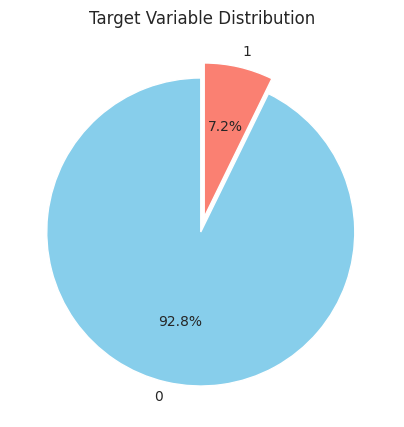

In [111]:
# Target Variable Distribution
target_counts = train_df["y"].value_counts()
plt.figure(figsize=(5,5))
plt.pie(target_counts, labels=target_counts.index, autopct="%1.1f%%",
        startangle=90, colors=["skyblue", "salmon"], explode=(0.05,0.05))
plt.title("Target Variable Distribution")
plt.show()

Class 0 dominates with 92.8%, while class 1 only accounts for 7.2%, indicating a highly imbalanced dataset.

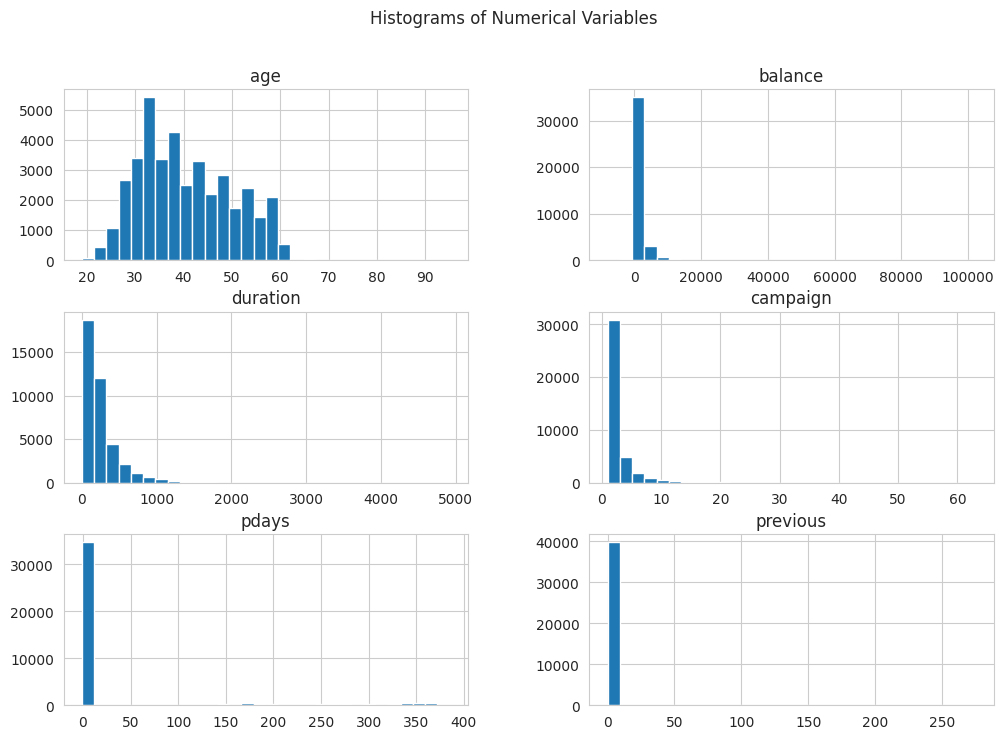

In [112]:
# Numerical Variables Distribution
nnum_cols = ["age", "balance", "duration", "campaign", "pdays", "previous"]
train_df[num_cols].hist(bins=30, figsize=(12,8))
plt.suptitle("Histograms of Numerical Variables")
plt.show()



*   Age is concentrated between 30–50 years.
*   Balance is highly skewed, with most values near zero but some extreme outliers.

*   Duration is right-skewed, with many short calls and few very long ones.
*   Campaign, pdays, and previous are also heavily skewed, with most values at very low counts.






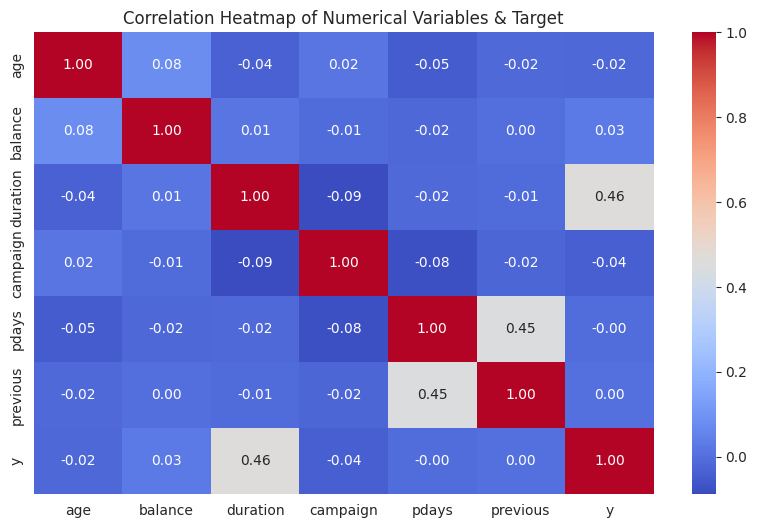

In [113]:
# Correlation Heatmap for Numerical Variables
plt.figure(figsize=(10,6))
sns.heatmap(train_df[num_cols + ["y"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap of Numerical Variables & Target")
plt.show()



*   Duration has the strongest positive correlation with the target (0.46), meaning longer calls are associated with higher conversion.




*   Pdays and previous are moderately correlated (0.45), indicating relationship between past contacts.

*   Other variables (age, balance, campaign) show very weak correlations with the target.





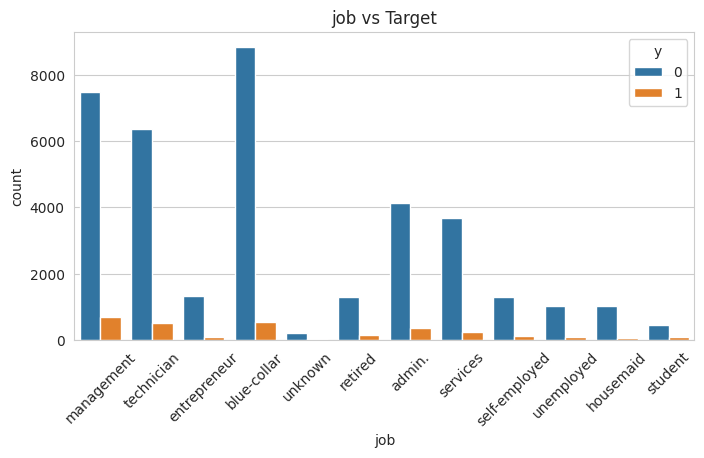

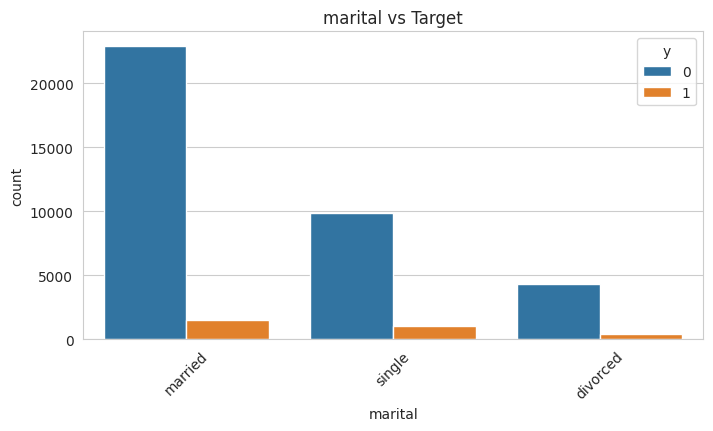

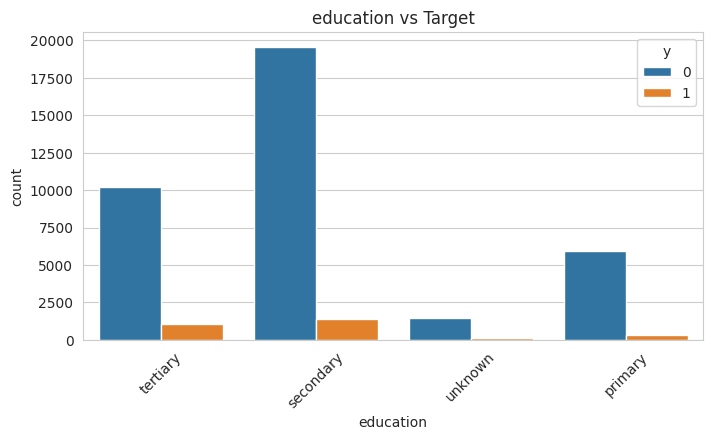

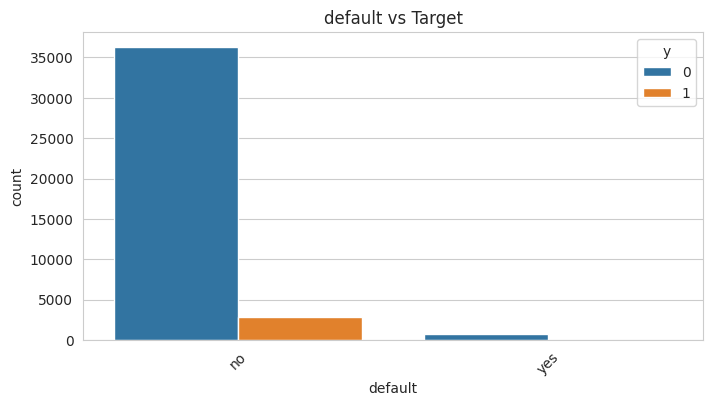

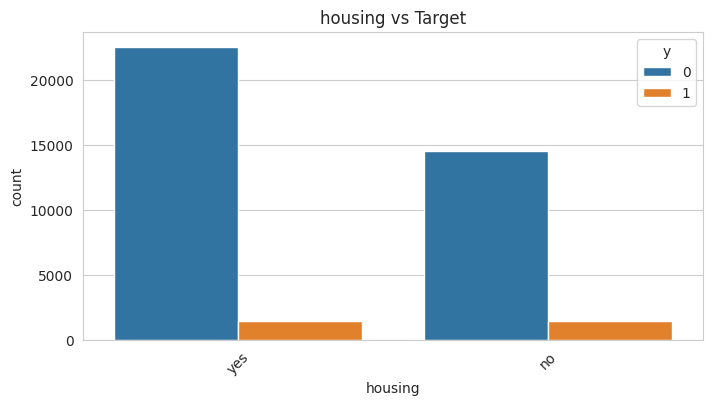

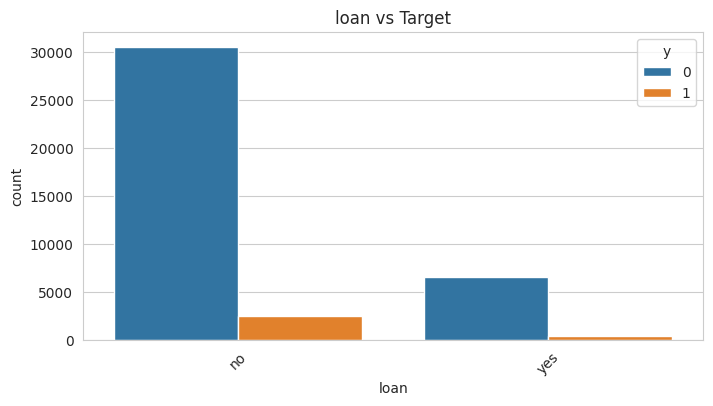

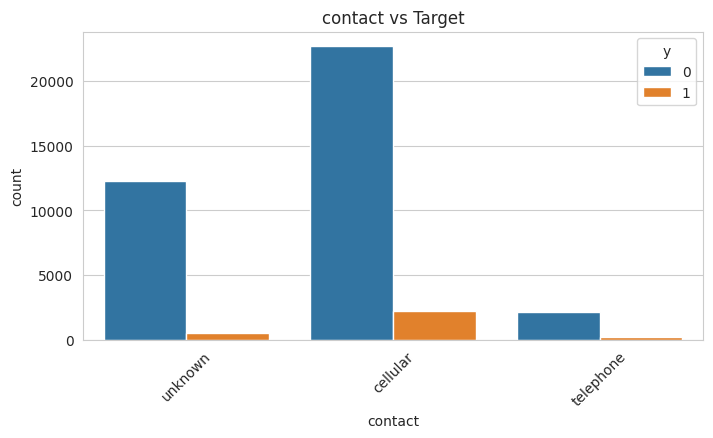

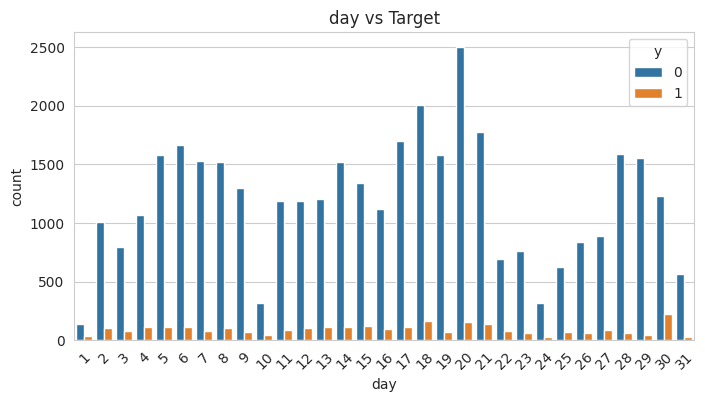

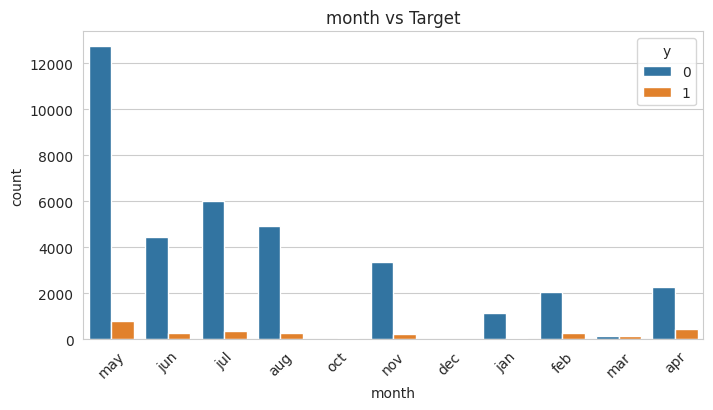

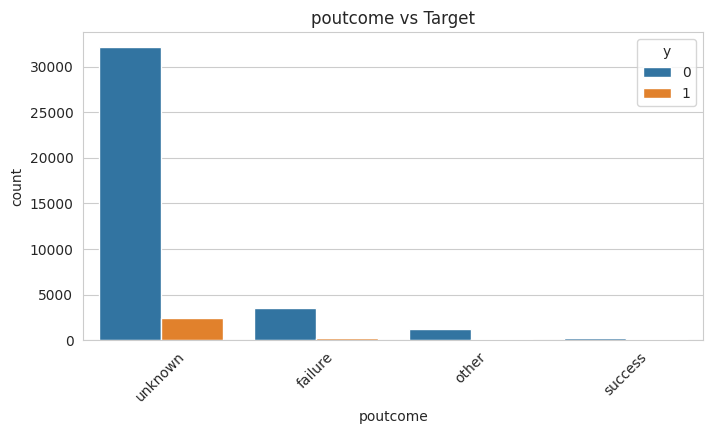

In [114]:
# Categorical vs Target
cat_cols = ["job", "marital", "education", "default", "housing", "loan",
            "contact", "day", "month", "poutcome"]
for col in cat_cols:
    plt.figure(figsize=(8,4))
    sns.countplot(x=col, hue="y", data=train_df)
    plt.title(f"{col} vs Target")
    plt.xticks(rotation=45)
    plt.show()



*   Job vs Target: Most subscriptions come from management and blue-collar workers, though overall acceptance rates remain low across all job categories.
*   Marital vs Target: Married individuals dominate the dataset, but single clients show a slightly higher proportion of positive responses.


*   Education vs Target: Secondary and tertiary education groups are the largest, with tertiary-educated clients showing a relatively higher subscription rate.
*   Default vs Target: Almost all clients have no default, and those with defaults rarely subscribe.

*   Housing vs Target: Clients with and without housing loans both show low subscription rates, with no major difference between groups.
*   Loan vs Target: Most clients do not have personal loans; those without loans show slightly higher subscription rates.

*   Contact vs Target: The cellular channel is the most effective, yielding the highest proportion of positive responses compared to telephone or unknown contacts.









# Data Pre-Processing

In [116]:
# Flag for pdays = -1 (never contacted before)
train_df["pdays_missing"] = (train_df["pdays"] == -1).astype(int)
test_df["pdays_missing"] = (test_df["pdays"] == -1).astype(int)

# Replace pdays = -1 with 0
train_df["pdays"] = train_df["pdays"].replace(-1, 0)
test_df["pdays"] = test_df["pdays"].replace(-1, 0)

# Flag for previous = 0 (no previous contacts)
train_df["previous_missing"] = (train_df["previous"] == 0).astype(int)
test_df["previous_missing"] = (test_df["previous"] == 0).astype(int)

In [117]:
# Encode Categorical Variables
label_cols = ["default", "housing", "loan", "y"]
one_hot_cols = ["job", "marital", "education", "contact", "day", "month", "poutcome"]

# Label Encoding (binary / yes-no cols)
le = LabelEncoder()
for col in label_cols:
    train_df[col] = le.fit_transform(train_df[col])
    if col != "y":
        test_df[col] = le.transform(test_df[col])

# One-hot encoding
train_df = pd.get_dummies(train_df, columns=one_hot_cols, drop_first=True)
test_df = pd.get_dummies(test_df, columns=one_hot_cols, drop_first=True)

In [118]:
# Feature Alignment
X = train_df.drop("y", axis=1)
y = train_df["y"]

train_cols = X.columns
test_df = test_df.reindex(columns=train_cols, fill_value=0)

# Model Training & Validation

In [120]:
# Handle Imbalance
scale_pos_weight = (y == 0).sum() / (y == 1).sum()
print("Scale Pos Weight:", scale_pos_weight)

Scale Pos Weight: 12.812154696132596


In [121]:
# Cross-validation with StratifiedKFold + Threshold Search
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

best_thresh = None
best_f1 = 0
auc_scores = []

for train_idx, valid_idx in skf.split(X, y):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

    model = XGBClassifier(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=5,
        scale_pos_weight=scale_pos_weight,
        random_state=42,
        eval_metric="logloss"
    )

    model.fit(X_train, y_train)

    # Predict probabilities
    valid_preds_proba = model.predict_proba(X_valid)[:, 1]

    # AUC
    auc = roc_auc_score(y_valid, valid_preds_proba)
    auc_scores.append(auc)

    # Search for best threshold (maximize F1)
    for t in np.linspace(0.1, 0.9, 81):
        preds = (valid_preds_proba >= t).astype(int)
        f1 = f1_score(y_valid, preds)
        if f1 > best_f1:
            best_f1 = f1
            best_thresh = t

print("Mean AUC:", np.mean(auc_scores))
print("Best Threshold:", best_thresh, "Best F1:", best_f1)

Mean AUC: 0.9490272226717245
Best Threshold: 0.79 Best F1: 0.6061946902654868


In [122]:
# Train Final Model on Full Train Data
final_model = XGBClassifier(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=5,
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    eval_metric="logloss"
)

final_model.fit(X, y)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, ...)

# Test Set Predictions

In [123]:
# Predictions on Test Set
test_preds_proba = final_model.predict_proba(test_df)[:, 1]
test_preds = (test_preds_proba >= best_thresh).astype(int)

# Create submission file
submission = pd.DataFrame({
    "id": test_ids,
    "y": test_preds
})
submission.to_csv("submission.csv", index=False)

In [126]:
submission.head()

,id,y
0,40100,1
1,40101,0
2,40102,0
3,40103,0
4,40104,1


# Conclusion

The XGBoost model effectively handles the imbalanced dataset using scale_pos_weight = 12.81. Cross-validation shows a high mean AUC of 0.949, indicating strong discriminative power. By optimizing the classification threshold to 0.79, the model achieves an F1 score of 0.606, balancing precision and recall for the minority class. Predictions on the test set are ready for submission, demonstrating that the model can reliably identify positive cases while accounting for class imbalance.